In [11]:
import re
import datetime
import tarfile
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path

import torchOTE
from torchOTE.data.process_dtcc_data import *
from torchOTE.data.process_spot_rate import * 
from torchOTE.data.utils import *
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

## In this notebook:

* Merging and sanity check on parquet slices of original DTCC data
* Outlier removal
* Tenor filtering (90 days max)

In [13]:
# insert PATH to download folder of DTCC pickle slices
PATH = Path('../../data/pickle_data_ndf_subset_currencies').resolve()
df = pd.concat(list(map(lambda x: pd.read_pickle(x),
                               list(PATH.glob('*.pickle')))))

In [14]:
# the dataframe contains a subset of the original DTCC record columns which we selected to be as
# clear as possible while at the same time retaining most information
df.head(1)

,EXECUTION_TIMESTAMP,PRICE_AFFECTING_TERM,OFF_FACILITY_SWAPS,EFFECTIVE_DATE,END_DATE,PLUS_USD,PLUS_CCY,CURRENCY,USD_AMOUNT,CCY_AMOUNT,NDF_RATE,SPOT_RATE,TERM_LENGTH,EXECUTION_TIMESTAMP_TIME,EXECUTION_TIMESTAMP_DATE
DISSEMINATION_ID,,,,,,,,,,,,,,,
113128881,2019-04-10 13:50:42,N,Y,2019-04-10,2019-08-13,False,False,CNY,550000.0,3696495.0,6.7209,6.9137,125.0,13:50:42,2019-04-10


In [15]:
n_zero_spots = df['SPOT_RATE'][df['SPOT_RATE']==0].count()
print(f'Initial length: {len(df)} \nVoid spot rates # rows: {n_zero_spots}')
# filter out zero spot rows
df = df[df['SPOT_RATE'] != 0]

n_negative_term = df['TERM_LENGTH'][df['TERM_LENGTH']<0].count()
print(f'Negative term # rows: {n_negative_term}')
# filter negative term rows
df = df[df['TERM_LENGTH']>0]

print(f'Final length: {len(df)}')

Initial length: 8654042 
 Void spot rates # rows: 38077
Negative term # rows: 538
Final length: 8611049


## Outliers 

In [20]:
df.describe()

,USD_AMOUNT,CCY_AMOUNT,NDF_RATE,SPOT_RATE,TERM_LENGTH
count,8.611049e+06,8.611049e+06,8.611045e+06,8.611049e+06,8.611049e+06
mean,8.179037e+06,8.857788e+09,1.596986e+03,1.399755e+03,6.227955e+01
std,2.511688e+07,7.535769e+10,1.047005e+05,3.613159e+03,4.689977e+02
min,0.000000e+00,0.000000e+00,0.000000e+00,2.974200e+00,1.000000e+00
25%,3.000000e+05,1.654866e+07,3.158700e+01,3.157200e+01,2.300000e+01
50%,1.000000e+06,1.300800e+08,6.497500e+01,6.504000e+01,3.400000e+01
75%,5.000000e+06,1.147250e+09,1.109000e+03,1.111310e+03,4.400000e+01
max,2.565750e+10,9.000000e+13,2.313289e+08,1.541700e+04,4.341900e+04


`NDF_RATE` has high variance. That has to be caused by outliers in the rounded amounts reported in the original dataset

In [21]:
spot_means = df['NDF_RATE'].groupby(df['CURRENCY']).mean()
spot_means

CURRENCY
CNY        8.265721
IDR    15486.406868
INR       72.161728
KRW     1215.722726
MYR        5.527504
PHP       65.935727
TWD       54.696176
Name: NDF_RATE, dtype: float64

In [22]:
ndf_means = df['SPOT_RATE'].groupby(df['CURRENCY']).mean()
ndf_means

CURRENCY
CNY        6.472393
IDR    13419.596538
INR       65.431185
KRW     1124.275004
MYR        3.806316
PHP       48.661698
TWD       30.897808
Name: SPOT_RATE, dtype: float64

In [23]:
spot_std = df['NDF_RATE'].groupby(df['CURRENCY']).std()
spot_std

CURRENCY
CNY       352.135710
IDR    365059.894663
INR      4163.864836
KRW     21856.852675
MYR       556.601668
PHP      2193.829880
TWD     12102.538249
Name: NDF_RATE, dtype: float64

In [24]:
ndf_std = df['SPOT_RATE'].groupby(df['CURRENCY']).std()
ndf_std

CURRENCY
CNY       0.288657
IDR    1111.373378
INR       3.676918
KRW      44.886517
MYR       0.445970
PHP       3.627029
TWD       1.037133
Name: SPOT_RATE, dtype: float64

In [36]:
currs = ['CNY', 'IDR', 'INR', 'KRW', 'MYR', 'PHP', 'TWD']
zs_list = []
for i in range(len(currs)):
    zs = (df['NDF_RATE'][df['CURRENCY']==currs[i]] - ndf_means[i])/ndf_std[i]
    zs = zs[abs(zs) > 3.5]
    zs_list.append(zs)
# filter original df by removing outliers
for zs in zs_list:
    df.drop(zs.index, inplace=True)

In [37]:
df['NDF_RATE'].groupby(df['CURRENCY']).mean() - df['SPOT_RATE'].groupby(df['CURRENCY']).mean()

CURRENCY
CNY    -0.005974
IDR   -70.670647
INR    -0.172111
KRW    -2.043703
MYR    -0.039963
PHP    -0.224453
TWD    -0.050512
dtype: float64

After removing outliers the difference in means becomes sensible. 

In [57]:
df['NDF_RATE'].groupby(df['CURRENCY']).std() - df['SPOT_RATE'].groupby(df['CURRENCY']).std()

CURRENCY
CNY     0.010412
IDR    63.219582
INR     0.131197
KRW    -0.558709
MYR    -0.002296
PHP     0.083134
TWD     0.026100
dtype: float64

In [58]:
# rows of outliers removed
8611049 - len(df)

13799

### Visualization sanity check

The plots below show ndf and spot rates as extracted from NDF trade records. The spot rate in particular
shows jumps since the trade records can have multiple entries in the same trading day, or there could be a period
of no recorded trades which results in a jump.

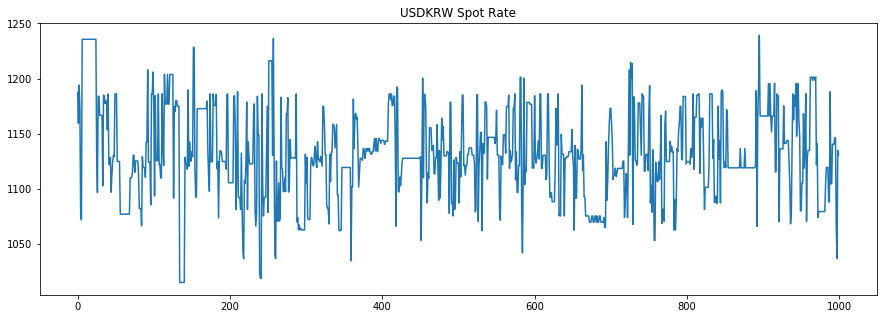

In [46]:
plt.figure(figsize=(15,5))
plt.plot(np.array(df['SPOT_RATE'][df['CURRENCY']=='KRW'][:1000]))
plt.title('USDKRW Spot Rate');

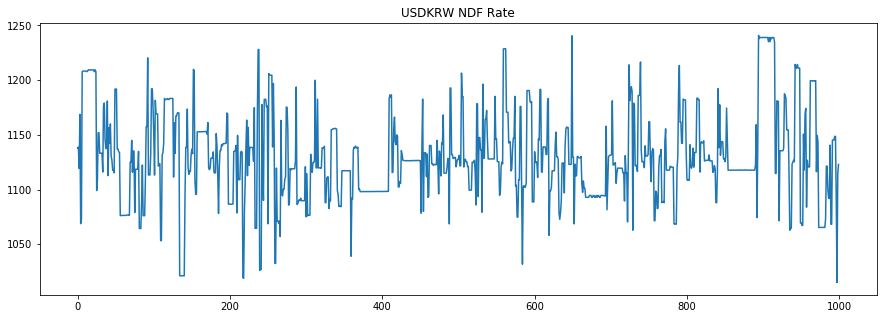

In [47]:
plt.figure(figsize=(15,5))
plt.plot(np.array(df['NDF_RATE'][df['CURRENCY']=='KRW'][:1000]))
plt.title('USDKRW NDF Rate');

## Returns

In [49]:
df['LOGRET'] = np.log(df['SPOT_RATE']) - np.log(df['NDF_RATE'])

In [50]:
sorted_df = df.sort_values(by=['LOGRET'], kind='mergesort', ascending=False)

In [51]:
# top trades by logret
sorted_df.head()

,EXECUTION_TIMESTAMP,PRICE_AFFECTING_TERM,OFF_FACILITY_SWAPS,EFFECTIVE_DATE,END_DATE,PLUS_USD,PLUS_CCY,CURRENCY,USD_AMOUNT,CCY_AMOUNT,NDF_RATE,SPOT_RATE,TERM_LENGTH,EXECUTION_TIMESTAMP_TIME,EXECUTION_TIMESTAMP_DATE,LOGRET
DISSEMINATION_ID,,,,,,,,,,,,,,,,
36795980,2015-10-27 09:04:16,N,Y,2015-10-27,2015-12-10,False,False,MYR,44000.0,99462.0,2.2605,4.26265,44.0,09:04:16,2015-10-27,0.634305
36795981,2015-10-27 09:04:16,N,Y,2015-10-27,2015-12-10,False,False,MYR,44000.0,99462.0,2.2605,4.26265,44.0,09:04:16,2015-10-27,0.634305
70056084,2017-08-25 10:08:39,N,Y,2017-08-25,2017-11-24,False,False,MYR,9000000.0,20430000.0,2.2700,4.11320,91.0,10:08:39,2017-08-25,0.594421
70053449,2017-08-25 10:08:39,N,Y,2017-08-25,2017-11-24,False,False,MYR,9000000.0,20430000.0,2.2700,4.11320,91.0,10:08:39,2017-08-25,0.594421
32298688,2015-07-21 06:36:16,N,Y,2015-07-21,2015-10-02,False,False,IDR,5.0,50500.0,10100.0000,14898.00000,73.0,06:36:16,2015-07-21,0.388692


In [52]:
sorted_df.groupby(['CURRENCY'])['LOGRET'].describe()

,count,mean,std,min,25%,50%,75%,max
CURRENCY,,,,,,,,
CNY,624850.0,0.000991,0.025122,-0.167807,-0.007680,0.000408,0.009576,0.178975
IDR,696918.0,0.005780,0.029039,-0.458143,-0.005661,0.004949,0.019829,0.388692
INR,2736964.0,0.002767,0.022543,-0.248099,-0.007176,0.003048,0.012431,0.305544
KRW,2167207.0,0.001800,0.024154,-0.199466,-0.010627,0.001597,0.015260,0.210423
MYR,655581.0,0.010586,0.035097,-0.326588,-0.008627,0.006008,0.025692,0.634305
PHP,595145.0,0.004780,0.018190,-0.340299,-0.005440,0.003370,0.013296,0.293775
TWD,1120581.0,0.001665,0.015764,-0.152466,-0.006185,0.000700,0.008424,0.143813


## Term Length Analysis

We now turn our attention at the distribution of `TERM LENGTH` values.

In [53]:
sorted_df['TERM_LENGTH'].describe()

count    8.597250e+06
mean     6.197863e+01
std      4.681930e+02
min      1.000000e+00
25%      2.300000e+01
50%      3.400000e+01
75%      4.400000e+01
max      4.341900e+04
Name: TERM_LENGTH, dtype: float64

A good percentage of these values seems unrealistic (`TERM_LENGTH` is computed in days). Some of these values are cause by an incorrect `EFFECTIVE_DATE` cell value.

In [54]:
sorted_df[sorted_df['TERM_LENGTH'] > 1500].head(10)

,EXECUTION_TIMESTAMP,PRICE_AFFECTING_TERM,OFF_FACILITY_SWAPS,EFFECTIVE_DATE,END_DATE,PLUS_USD,PLUS_CCY,CURRENCY,USD_AMOUNT,CCY_AMOUNT,NDF_RATE,SPOT_RATE,TERM_LENGTH,EXECUTION_TIMESTAMP_TIME,EXECUTION_TIMESTAMP_DATE,LOGRET
DISSEMINATION_ID,,,,,,,,,,,,,,,,
4356683,2011-11-10 17:20:55,N,Y,2011-11-10,2016-12-20,False,False,MYR,110000.0,3.543650e+05,3.221500,4.49250,1867.0,17:20:55,2011-11-10,0.332562
42342254,2012-12-06 19:46:19,N,Y,2012-12-06,2017-03-20,False,False,MYR,350000.0,1.135363e+06,3.243894,4.44335,1565.0,19:46:19,2012-12-06,0.314634
12316254,2014-03-28 07:31:51,N,Y,2010-11-04,2015-11-05,False,False,IDR,5000000.0,5.305000e+10,10610.000000,13679.50000,1827.0,07:31:51,2014-03-28,0.254101
12316255,2014-03-28 07:31:51,N,Y,2010-11-04,2015-11-05,False,False,IDR,5000000.0,5.305000e+10,10610.000000,13679.50000,1827.0,07:31:51,2014-03-28,0.254101
32066164,2014-03-28 07:31:51,N,Y,2010-11-04,2015-11-05,False,False,IDR,5000000.0,5.305000e+10,10610.000000,13679.50000,1827.0,07:31:51,2014-03-28,0.254101
32066165,2014-03-28 07:31:00,N,Y,2010-11-04,2015-11-05,False,False,IDR,5000000.0,5.305000e+10,10610.000000,13679.50000,1827.0,07:31:00,2014-03-28,0.254101
32066166,2014-03-28 07:31:51,N,Y,2010-11-04,2015-11-05,False,False,IDR,5000000.0,5.305000e+10,10610.000000,13679.50000,1827.0,07:31:51,2014-03-28,0.254101
32066167,2014-03-28 07:31:00,N,Y,2010-11-04,2015-11-05,False,False,IDR,5000000.0,5.305000e+10,10610.000000,13679.50000,1827.0,07:31:00,2014-03-28,0.254101
4356680,2011-11-10 17:20:08,N,Y,2011-11-10,2016-09-20,False,False,MYR,72000.0,2.322000e+05,3.225000,4.14700,1776.0,17:20:08,2011-11-10,0.251452


We will only take into account tenors of medium length. Therefore we drop `TERM_LENGHTs` > 90

In [55]:
sorted_df = sorted_df[sorted_df['TERM_LENGTH'] <= 90]

In [56]:
sorted_df.groupby(['CURRENCY'])['TERM_LENGTH'].describe()

,count,mean,std,min,25%,50%,75%,max
CURRENCY,,,,,,,,
CNY,385569.0,32.053900,21.188291,1.0,15.0,32.0,39.0,90.0
IDR,615991.0,33.150158,19.738354,1.0,19.0,34.0,38.0,90.0
INR,2529513.0,30.185054,17.394328,1.0,17.0,32.0,35.0,90.0
KRW,1982073.0,33.118978,16.720636,1.0,27.0,34.0,35.0,90.0
MYR,579537.0,32.621481,18.579139,1.0,21.0,34.0,36.0,90.0
PHP,515987.0,33.423811,20.399122,1.0,20.0,33.0,38.0,90.0
TWD,992848.0,33.219944,18.394267,1.0,22.0,34.0,36.0,90.0


## Save

In [38]:
import os
PATH = os.path.realpath('../../data')
if not os.path.exists(f'{PATH}/final'):
    os.mkdir(f'{PATH}/final')
PATH = os.path.realpath('../../data/final')

PATH = os.path.realpath('../../data/final')
sorted_df.to_pickle(f'{PATH}/dtcc')